# Случайные процессы. Прикладной поток.
## Практическое задание 2

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 2"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `2.N.ipynb` и `2.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.

In [134]:
import math
import re
import numpy as np
import scipy.stats as sps
import pandas as pd
from collections import Counter  # это может пригодиться
from BranchingProcess import Person, BranchingProcess, read_from_files

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity as KDE
from statsmodels.sandbox.stats.multicomp import multipletests

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 16})
%matplotlib inline

В предыдущем задании вы сделали оценку закона размножения. Скорее всего у вас получилось геометрическое распределение. Первую часть данного задания выполните, оценив закон размножения геометрическим распределением.

## 1. Описательный анализ

Большая часть кода, необходимая для проведения данного анализа, является технической и основывается на работе с пакетом `BranchingProcess`. Поэтому данный код полностью вам выдается, вам нужно только выполнить его, подставить имена файлов. Кроме того, код анализа позволит вам лучше понять структуру данных.

Считайте данные с помощью предложенного кода. Посчитайте количество родословных.

In [320]:
processes = read_from_files(['data/L.txt', 'data/G.txt', 
                             'data/F.txt', 'data/N.txt', 
                             'data/U.txt', 'data/R.txt', 
                             'data/S.txt', 'data/K.txt', 
                             'data/D.txt', 'data/J.txt'])
print(len(processes))

83681


В имеющихся данных очень много людей, про которых известно лишь то, что они когда-то существовали. Обычно их фамилия неизвестна (вместо фамилии у них может стоять, к примеру, `B-290`), а у некоторых из них неизвестен даже пол, не говоря уже о родителях и детях. Такие данные стоит удалить.

Удалите все процессы, состоящие только из одного поколения (в котором, естественно, будет только один человек).
Сколько осталось процессов?

In [321]:
for i in range(len(processes))[::-1]:
    if len(processes[i].generations) < 2:
        del processes[i]

print(len(processes))

23959


Рассмотрим выборку из колличеств детей

In [14]:
sample = []
for pedigree in processes:
    for i, generation in enumerate(pedigree.generations):
        for person in generation:
            child_count = 0
            for child_name in person.children:
                for child_person in pedigree.generations[i - 1]:
                    if child_person.name == child_name \
                    and child_person.gender == 'male'  \
                    and person.name in child_person.parents:
                        
                        child_count += 1
                        break
            sample.append(child_count)
            
sample = np.array(sample)
positive_sample = sample[sample > 0]

## 2.  Оценка параметров

#### Геометрическое распределение

$$ \prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) = \prod_{i=1}^s \left(1-\theta\right)^{Y_i - 1} \theta $$ Прологарифмировав получим
$$ \sum_{i=1}^s \left( \left(Y_i - 1\right) \ln{\left(1 - \theta\right)} + \ln{\theta} \right) $$
Возьмем производную и приравняем к $0$
$$ \sum_{i=1}^s \left(\frac{1 - Y_i}{1 - \theta} + \frac{1}{\theta} \right) = \frac{s - \sum_{i=1}^{s} Y_i}{1 - \theta} + \frac{s}{\theta} = 0 $$
Следовательно
$$ \theta \left( \sum_{i=1}^{s} Y_i - s \right) = s \left( 1 - \theta \right) \quad \Rightarrow \quad \theta = \frac{1}{\overline{Y}} $$

In [15]:
theta_geom = 1 / positive_sample.mean()
print("theta =", theta_geom)

theta = 0.53340893231


** Часть 1. **

Используя оценку закона размножения, посчитайте вероятность вырождения процесса (ее оценку, если говорить строго). Если эта вероятность равна 1, посчитайте математическое ожидание общего числа частиц в процессе (его оценку, если говорить строго).

Так как $$\xi \sim (1-p)^{k}p$$ То математическое ожидание $$E \xi = \frac{1-p}{p} $$

In [16]:
print((1-theta_geom)/theta_geom)

0.874734260016


Пусть $q$ - вероятность вырождения, тогда по теореме из лекции так как$$ \mu = E\xi < 1 \quad \Rightarrow \quad q = 1$$

Теперь посчитаем математическое ожидание количества частиц. Для начала посчитаем $\phi_\xi(z)$ при условии, что $\xi$ имеет геметрическое распределение. ($z \in [0, 1]$) $$ \phi_\xi(z) = E z^{k} = \sum_{k = 0}^{+\infty} z^k (1-p)^kp = \frac{p}{(p-1)z + 1}$$ 
Теперь найдем $\rho(z)$ $$\rho(z) = z\phi_{\xi}\left(\rho(z)\right) \quad \Rightarrow \quad \rho(z) = \frac{zp}{(p-1)\rho(z)+1} \quad \Rightarrow$$ $$ \Rightarrow \quad (1-p)\rho^2(z)-\rho(z) + zp = 0 $$ 

$$\rho(z)_{1,2} = \frac{1 \pm \sqrt{1-4p(1-p)z}}{2(1-p)} $$

$\rho(0) = 0$ следовательно надо взять выражение со знаком минус

$$\rho(z) = \frac{1 - \sqrt{1-4p(1-p)z}}{2(1-p)} $$

$$\rho'(z) = \frac{p}{\sqrt{4p^2z-4pz+1}} \quad \Rightarrow \quad E Y = \rho'(1) = \frac{p}{\sqrt{4p^2-4p+1}}$$

In [21]:
print((theta_geom)/math.sqrt(4*theta_geom**2 - 4*theta_geom + 1))

7.98302872063


Предположим теперь, что каждый род является самостоятельным процессом (а не частью одного большого) и имеет свой закон размножения. Сделайте оценку закона размножения каждого рода геометрическим распределением. Если в роду имеются данные о менее 10 мужчинах, то в качестве оценки закона размножения возьмите общую оценку закона размножения, полученную ранее (в случае одного большого процесса). Если в роду нет мужчин, то закон размножения должен быть вырожденным: значение 0 принимается с вероятностью 1. Посчитайте вероятность вырождения каждого процесса. Сколько процессов выродится с вероятностью 1? Сколько процессов имеют вероятность вырождения менее 0.5?

In [41]:
thetas = []
less_then_10 = 0
for pedigree in processes:
    for i, generation in enumerate(pedigree.generations):
        generation_sample = []
        males_count = 0
        for person in generation:
            if person.gender == 'male':
                males_count += 1
                
            child_count = 0
            for child_name in person.children:
                for child_person in pedigree.generations[i - 1]:
                    if child_person.name == child_name \
                    and child_person.gender == 'male'  \
                    and person.name in child_person.parents:
                        
                        child_count += 1
                        break
            generation_sample.append(child_count)
        
        if males_count == 0:
            less_then_10 += 1
            thetas.append(1) # в итоговой формуле точно выродится
        elif males_count < 10:
            thetas.append(theta_geom)
        else:
            generation_sample = np.array(generation_sample);
            positive_generation_sample = \
                generation_sample[generation_sample > 0]
            if len(positive_generation_sample) == 0 or \ 
            positive_generation_sample.mean() == 0:
                generation_theta = 1
            else:
                generation_theta = 1 / positive_generation_sample.mean()
            thetas.append(generation_theta)
thetas = np.array(thetas)

Если $q$ вероятность вырождения процесса и $\mu > 1$, то $$q = \phi_\xi(q) \quad \Rightarrow \quad q = \frac{p}{1-q(1-p)} $$

$$ q_{1,2} = \frac{1 \pm (1-2p)}{2(1-p)} \quad \Rightarrow \quad q_1 = 1 \quad q_2 = \frac{p}{1-p} $$ 

В итоге $q = \frac{p}{1 - p}$

In [48]:
print("Общее число процессов: " + str(len(thetas)))
print("Число процессов с количеством мужчин меньших 10: ", less_then_10)
print("Число вырождающихся с вероятностью 1: " 
      + str(len(thetas[(1-thetas)/thetas <= 1])))
thetas_non_die = thetas[(1-thetas)/thetas > 1]
print("Число вырождающихся с вероятностью менее 0.5: " 
      + str(len(thetas_non_die[(thetas_non_die)/(1 - thetas_non_die) <= 0.5])))

Общее число процессов: 78242
Число процессов с количеством мужчин меньших 10:  11604
Число вырождающихся с вероятностью 1: 78237
Число вырождающихся с вероятностью менее 0.5: 5


** Часть 2. **

`Вопрос:` Как будет меняться численность населения и количество фамилий в течении ближайших 200 лет от текущего момента времени? Помимо оценок требуется построить доверительные интервалы.

Условие данного задания не предполагает какого-либо конкретного алгоритма решения, поэтому вам нужно его придумать самим. Вместе с решением вам нужно прислать достаточно подробное текстовое описание вашего способа решения задачи. В этом описании должны быть пояснения, почему вы выбрали такой метод решения. Оцениваться будет не только оригинальность решения, но и его логическая или научная обоснованность. Если вы хотите использовать какие-либо модели, о которых вы узнали из дополнительных источников (спецкурсы, онлайн-курсы, книги, научные статьи и т.д.), приведите описание этих моделей.

Идеи решения с обсуждения на семинаре:
1. Моделирование процесса на несколько поколений, то есть генерирование новых поколений в соответствии с найденным законом размножения. При генерации стоит генерировать только количество потомков, а не самих людей, иначе не хватит оперативной памяти.
2. Для построения доверительных интервалов можно провести моделирование несколько раз (100-200).
3. Количество поколений, которое нужно сгенерировать, можно определить, оценив среднее время между поколениями.
4. Для каждого рода количество поколений, которое нужно сгенерировать, может быть разным в зависимости от времени жизни последнего известного поколения.
5. Длина временного интервала между поколениями может меняться во времени. Можно попробовать применить регрессию.
6. Закон размножения так же может меняться со временем.

Будем считать линейную регрессию по средней продолжительности жизни $$ age = \widehat{\theta_1} + \widehat{\theta_2} \cdot year $$

In [290]:
sum_age = {}
count = {}

for pedigree in processes:
    for i, generation in enumerate(pedigree.generations):
        for person in generation:
            sum_datebirth = 0
            child_count = 0
            if person.birthday != '' and person.deathdate != '':
                life_length = (float(person.deathdate.split('-')[0]) - \
                               float(person.birthday.split('-')[0]))

                if life_length > 30 and life_length < 120:
                    if person.birthday.split('-')[0] in sum_age:
                        sum_age[person.birthday.split('-')[0]] += life_length
                    else:
                        sum_age[person.birthday.split('-')[0]] = life_length
                    if person.birthday.split('-')[0] in count:
                        count[person.birthday.split('-')[0]] += 1
                    else:
                        count[person.birthday.split('-')[0]] = 1
                        
mid_age = {}
for key in sum_age:
    mid_age[key] = sum_age[key] / count[key]

In [291]:
years_data = []
mid_age_data = []
for key in sorted(mid_age.keys()):
    years_data.append(float(key))
    mid_age_data.append(mid_age[key])

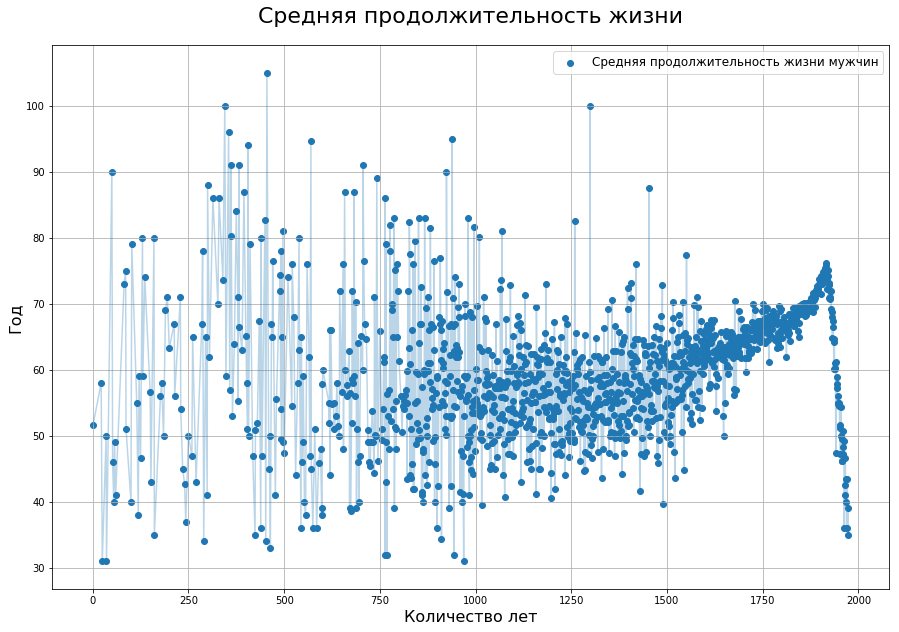

In [292]:
grid = np.linspace(np.min(years_data) - 1, np.max(years_data) + 1, 500)

plt.figure(figsize=(15, 10))

plt.plot(years_data, mid_age_data, alpha=0.3, label=None)
plt.scatter(years_data, mid_age_data, label='Средняя продолжительность жизни мужчин')

# plt.plot(grid, dataLR.predict(list(zip(np.ones_like(grid), grid))), label="Модель")

plt.title('Средняя продолжительность жизни', y=1.03, fontsize=22)
plt.xlabel('Количество лет', fontsize=16)
plt.ylabel('Год', fontsize=16)

plt.legend(fontsize=12)
plt.grid()
plt.show()

Как можно заметить статистика в конце не очень хорошая поскольку данные обрубаются и выборка не велика, поэтому для хорошей оценки уберем последние года

In [304]:
trimmed_years_data = years_data[:len(years_data) - 55]
trimmed_mid_age_data = mid_age_data[:len(mid_age_data) - 55]

In [305]:
dataLR = LinearRegression()
dataLR.fit(list(zip(np.ones_like(trimmed_years_data[::2]), trimmed_years_data[::2])), 
           trimmed_mid_age_data[::2])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

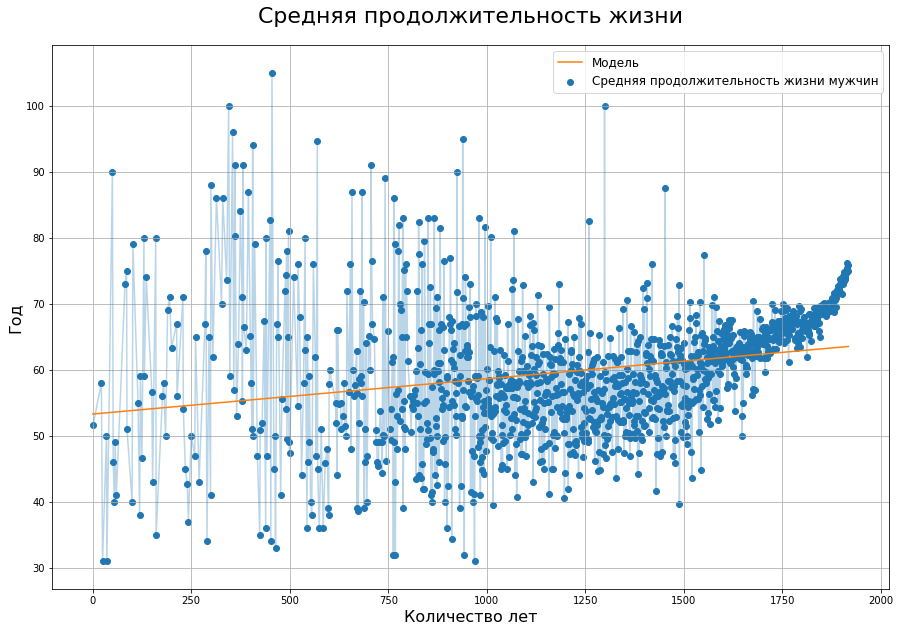

In [306]:
grid = np.linspace(np.min(trimmed_years_data) - 1, np.max(trimmed_years_data) + 1, 500)

plt.figure(figsize=(15, 10))

plt.plot(trimmed_years_data, trimmed_mid_age_data, alpha=0.3, label=None)
plt.scatter(trimmed_years_data, trimmed_mid_age_data, 
            label='Средняя продолжительность жизни мужчин')

plt.plot(grid, dataLR.predict(list(zip(np.ones_like(grid), grid))), 
         label="Модель")

plt.title('Средняя продолжительность жизни', y=1.03, fontsize=22)
plt.xlabel('Количество лет', fontsize=16)
plt.ylabel('Год', fontsize=16)

plt.legend(fontsize=12)
plt.grid()
plt.show()

In [307]:
mean_absolute_error(trimmed_mid_age_data[1::2], 
                    dataLR.predict(list(zip(np.ones_like(trimmed_years_data[1::2]), 
                                            trimmed_years_data[1::2]))))

6.6719512947895794

Сравним со средними показателями по России

In [308]:
middle_age = pd.read_csv('middle_age.csv', 
                         names=['Year', 'Age'],
                         sep=';')
middle_age['Age'] = list(map((lambda x: float(x)), middle_age['Age']))
middle_age['Ones'] = np.ones_like(middle_age['Age'])
middle_age.head()

,Year,Age,Ones
0,1950,53.9,1.0
1,1951,53.9,1.0
2,1952,53.9,1.0
3,1953,53.9,1.0
4,1954,57.0,1.0


In [309]:
russiaLR = LinearRegression()
russiaLR.fit(middle_age[['Ones', 'Year']].values, middle_age['Age'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

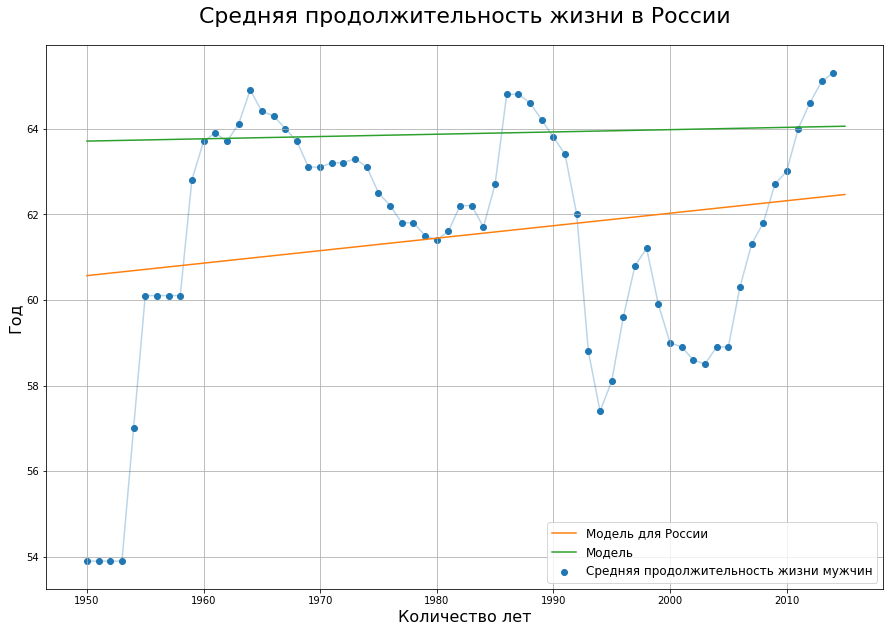

In [310]:
grid = np.linspace(np.min(middle_age['Year']), np.max(middle_age['Year']) + 1, 500)

plt.figure(figsize=(15, 10))

plt.plot(np.array(middle_age['Year']), np.array(middle_age['Age']), 
         alpha=0.3, label=None)
plt.scatter(np.array(middle_age['Year']), np.array(middle_age['Age']), 
            label='Средняя продолжительность жизни мужчин')

plt.plot(grid, russiaLR.predict(list(zip(np.ones_like(grid), grid))), 
         label='Модель для России')
plt.plot(grid, dataLR.predict(list(zip(np.ones_like(grid), grid))), 
         label='Модель')

plt.title('Средняя продолжительность жизни в России', y=1.03, fontsize=22)
plt.xlabel('Количество лет', fontsize=16)
plt.ylabel('Год', fontsize=16)

plt.legend(fontsize=12)
plt.grid()
plt.show()

In [391]:
generation_counters = []
ind = -1
for pedigree in processes:
    for i, generation in enumerate(pedigree.generations):
        generation_counters.append(0)
        ind += 1
        for person in generation:
            if person.birthday != '' and person.deathdate != '' \
            and float(person.birthday.split('-')[0]) > 1900 and  \
            person.gender == 'male':
                generation_counters[ind] += 1

In [392]:
print(sum(generation_counters))
generation_counters = np.array(generation_counters)

12326


In [432]:
years = [2017]
ind = 0
while years[ind] < 2217:
    years.append(years[ind] + LR.predict([(1, x_i[ind][0])]) / 2)
    ind += 1

years = np.array(years)

tests = []
for i in range(10):
    tests.append([np.array(generation_counters)])
    
for i in range(10):
    for j in range(len(years) - 1):
        tests[i].append(np.zeros_like(generation_counters))
        for k, num in enumerate(tests[i][j]):
            if num > 0:
                tests[i][j + 1][k] = sum(sps.geom(theta_geom).rvs(size=num))
            else:
                tests[i][j + 1][k] = 0
    tests[i] = np.array(tests[i])

In [448]:
count_tests = []

for i in range(10):
    count_tests.append(tests[i].sum(axis=1))
    
count_tests = np.array(count_tests)
middle_counts = count_tests.sum(axis=0) / 10
max_counts = count_tests.max(axis=0)
min_counts = count_tests.min(axis=0)

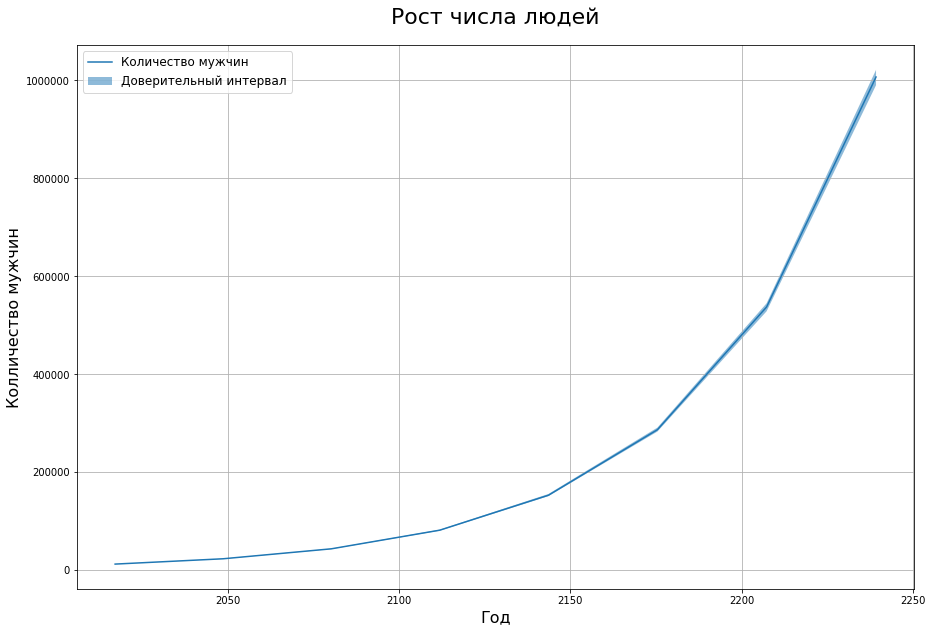

In [451]:
plt.figure(figsize=(15, 10))

plt.fill_between(years, max_counts, min_counts, alpha=0.5, label='Доверительный интервал')
plt.plot(years, middle_counts, label='Количество мужчин')

plt.title('Рост числа людей', y=1.03, fontsize=22)
plt.xlabel('Год', fontsize=16)
plt.ylabel('Колличество мужчин', fontsize=16)

plt.legend(fontsize=12)
plt.grid()
plt.show()